# Filter Analysis

In [2]:
import numpy as np
import os
import pandas as pd
import pyxdf

#Filtering
from scipy.signal import kaiserord, filtfilt, firwin, freqz, windows, cheby2, iirnotch, welch

#Plotting
from pylab import figure, clf, plot, subplot, xlabel, ylabel, xlim, ylim, title, grid, axes, show, suptitle, Rectangle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context = "paper")#, style="whitegrid")

In [3]:
#Load a recording
file_path = "C:/Users/s_gue/Desktop/master_project/sven-thesis/data/recordings/sub-P001/ses-S001/eeg/sub-P001_ses-S001_task-Default_run-001_eeg.xdf"
data, _ = pyxdf.load_xdf(file_path)
chan_names = ["PO10", "O10", "O9", "PO9", "O1", "OZ", "O2", "PO"]
fs = 250
event_time = 2 #seconds

#Sometimes Lab Recorder accidentally adds another empty stream to the xdf file, so we need to check and get rid of it
if len(data) > 2:
    for i, _ in enumerate(data):
        if 0 in data[i]["time_series"].shape:
            data.pop(i)
    
eeg, pp = (data[0], data[1]) if data[0]["info"]["name"][0] == "UN-2019.05.50" else (data[1], data[0])
eeg_time_series = eeg["time_series"] #EEG time series data.
event_time_series = pp["time_series"] #Event time series data.
eeg_timestamps = eeg["time_stamps"] #Timestamps for each sample in the EEG time series.
event_timestamps = pp["time_stamps"] #Timestamps for each sample in the event time series.

# Find the indices of the closest EEG timestamps to each event timestamp
diff = np.subtract.outer(event_timestamps, eeg_timestamps)
eeg_indices = np.argmin(np.abs(diff), axis=1)
start = eeg_indices[0] #index at which first event starts

# Initialize an array to hold the labels for the EEG samples
labels = np.empty(eeg_timestamps.shape, dtype=int)
labels.fill(90) #Fill with 90 (break)
group_labels = np.copy(labels)

# Grab the EEG data from first event onwards and turn into dataframe
eeg_data = eeg_time_series[start:, :8]
out = pd.DataFrame(eeg_data, columns=chan_names)

# Iterate over the events
for i in range(len(eeg_indices) - 1):
    # Label all EEG samples + 2s after the event with the event's label, rest is Break (90)
    event_end = int(eeg_indices[i] + event_time*fs)
    group_labels[eeg_indices[i]:event_end] = int(event_time_series[i][1])
    labels[eeg_indices[i]:event_end] = int(event_time_series[i][2])

# Label the remaining EEG samples with the last event's label
labels[eeg_indices[-1]:int(eeg_indices[-1]+event_time*fs)] = event_time_series[-1][1]
group_labels[eeg_indices[-1]:int(eeg_indices[-1]+event_time*fs)] = event_time_series[-1][2]
df = pd.concat([pd.DataFrame({'time': eeg_timestamps[start:], 'label': labels[start:], 'group_label': group_labels[start:]}), out], axis=1)
df = df[:int(eeg_indices[-1]+event_time*fs)] #Remove the rest of the EEG samples that don't have a label

#BUGFIX: For some reason, Psychopy sometimes switches group_label with the label for one example. This fixes that.
incorrect_group_label = df[(df['group_label'] > 19) & (df['group_label'] != 90)]["group_label"].unique()
labels_per_group = df[df['group_label']<20]['group_label'].value_counts()

if len(incorrect_group_label) > 0:
    mask = (df['group_label'] == incorrect_group_label[0])
    df.loc[mask, ['group_label', 'label']] = df.loc[mask, ['label', 'group_label']].values

#In the unfortunate case where the group label switches to an actual group label:
elif labels_per_group[labels_per_group.idxmax()] > 30*500:
    big_group = labels_per_group.idxmax() # Get the group label with the most instances
    group_max_instances = df[df["group_label"] == big_group] # Select instances in group_max
    label_counts = group_max_instances["label"].value_counts().sort_index() # Get the value counts for the labels within group_max
    for label in label_counts.index: # Find the label which doesn't have an adjacent label
        if (label - 1 not in label_counts.index) and (label + 1 not in label_counts.index):
            faulty_label = label
            mask = (df['group_label'] == big_group) & (df["label"] == faulty_label)
            df.loc[mask, ['group_label', 'label']] = df.loc[mask, ['label', 'group_label']].values
            break

#Get the whole eeg recording and one trial (for time domain plots)
trial = 42
eeg_data_all = df[chan_names].to_numpy()
eeg_data_trial = df[df["label"] == trial][chan_names].to_numpy()

#Get start and end point for the trial:
start_idx = df[df["label"] == trial].index[0]
end_idx = df[df["label"] == trial].index[-1]

Stream 3: Calculated effective sampling rate 0.0000 Hz is different from specified rate 250.0000 Hz.


## Filter function and filter effect in frequency domain

C:\Users\s_gue\AppData\Local\Temp\ipykernel_14736\508177615.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  subplot(1,3,1)


(0.0, 1.1)

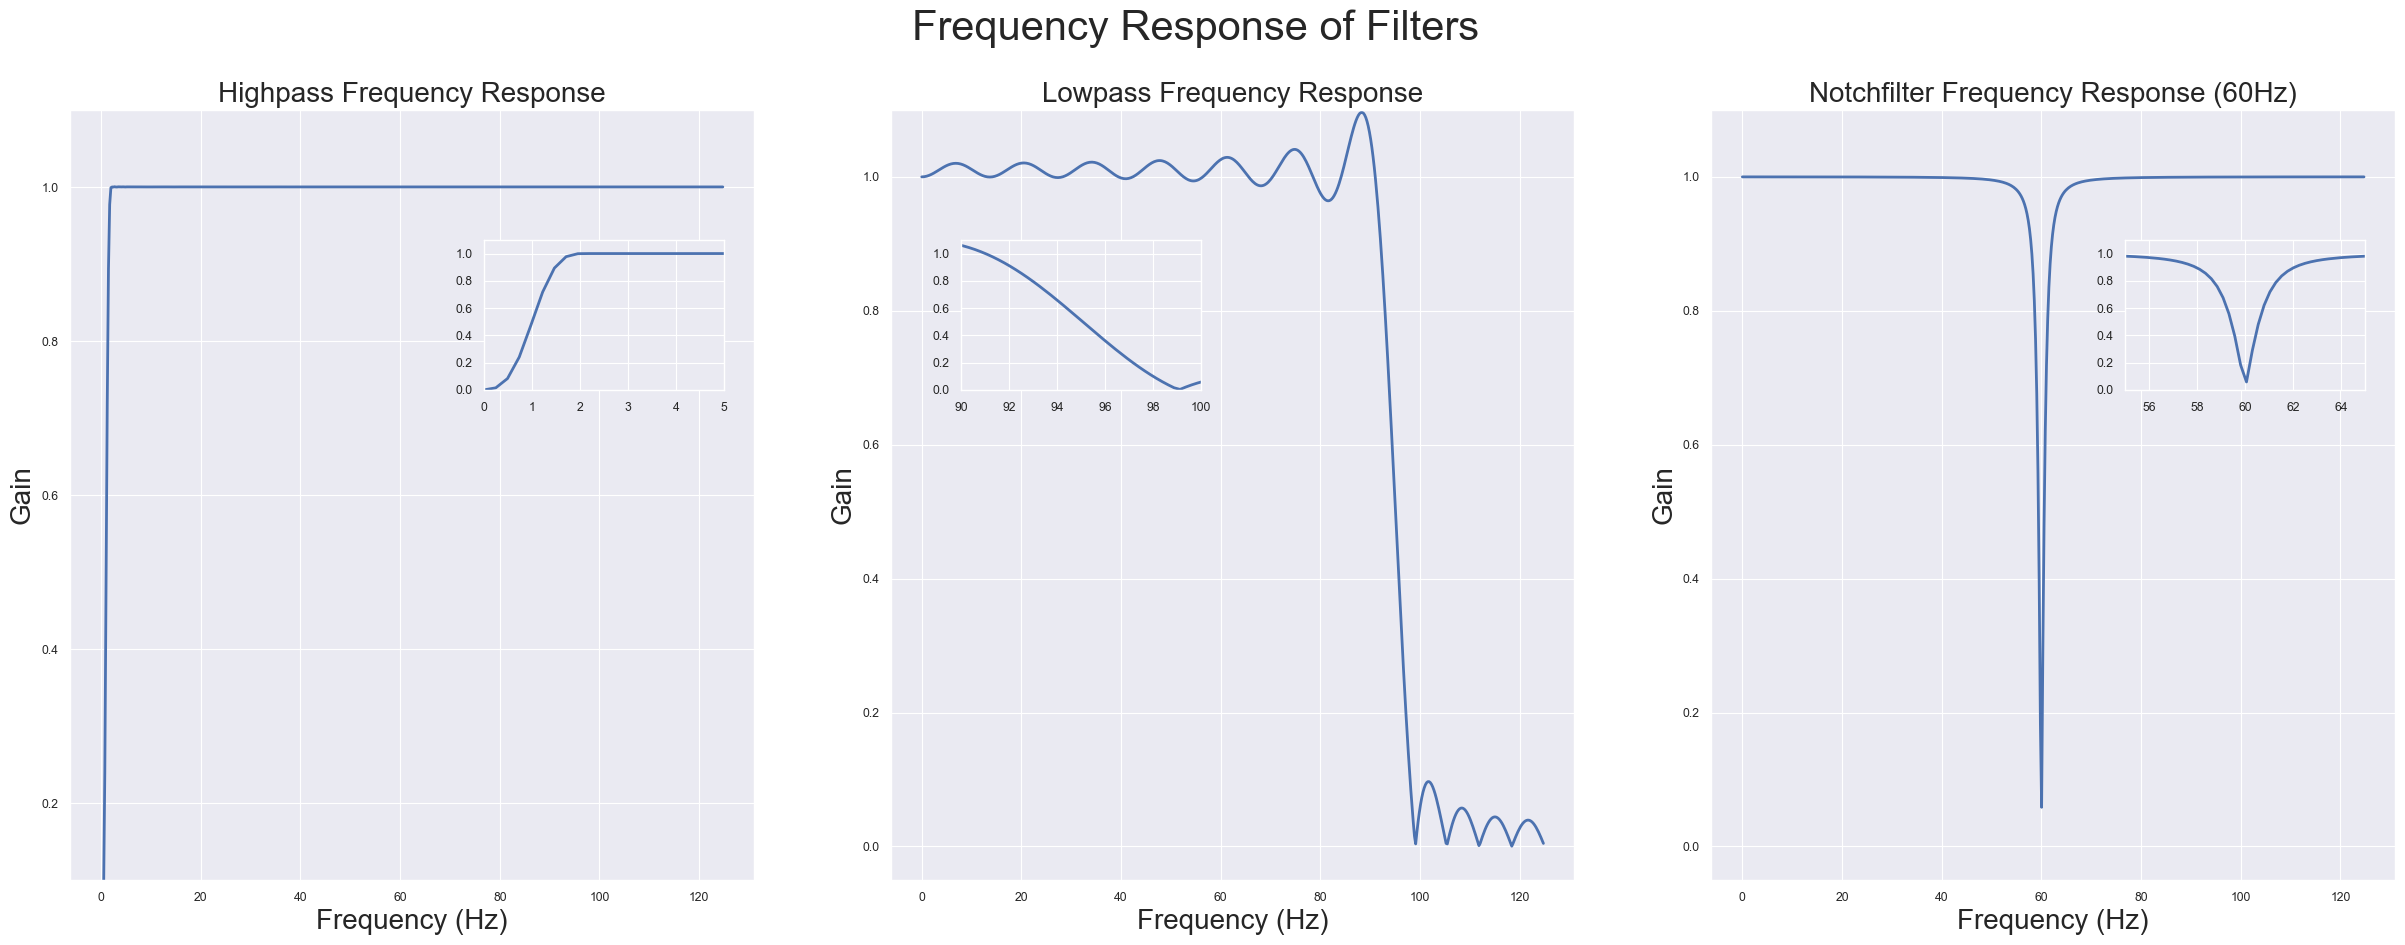

In [5]:
fs = 250
#n_samples = eeg_data.shape[0]
nyq = fs/2.0

#Cutoff Frequencies
high_cut = 1.0/nyq
low_cut = 95/nyq
notch_cut1 = 60 #normalized inside scipy function

#Kaiser
#Highpass and Lowpass Filter 
#Width of transition from pass to stop relative to Nyquist.
width_low = 6.0/nyq 
width_high = 2.0/nyq

#Desired attenuation in the stop band, in dB.
ripple_db_low = 20.0
ripple_db_high = 72.0

#Compute the order and Kaiser parameter for the FIR filter.
N_low, beta_low = kaiserord(ripple_db_low, width_low)
N_high, beta_high = kaiserord(ripple_db_high, width_high)

#Use firwin with a Kaiser window to create a lowpass and highpass FIR filter.
taps_low = firwin(N_low, low_cut,window=('kaiser', beta_low)) #Kaiser: window=('kaiser', beta_low) or ('chebwin', 0.0002)
taps_high = firwin(N_high, high_cut, window=('kaiser', beta_high), pass_zero=False) 
w_h, h_h = freqz(taps_high, worN=512)
w_l, h_l = freqz(taps_low, worN=512)


#Notchfilter
b_60, a_60 = iirnotch(60.0, 30, fs=250)
w_60, h_60 = freqz(b_60, a_60, worN=512)


#Plotting:
#Filter Frequency Responses
figure(1, figsize=(30,10))
clf()
grid(True)
suptitle('Frequency Response of Filters', fontsize=30)

#Highpass
subplot(1,3,1)
plot((w_h/np.pi)*nyq, np.absolute(h_h), linewidth=2)
xlabel('Frequency (Hz)', fontsize = 20)
ylabel('Gain', fontsize = 20)
title('Highpass Frequency Response', fontsize = 20)
ylim((0.1, 1.1))

#Upper inset plot.
ax2 = axes([0.263, 0.6, 0.08, 0.15])
plot((w_h/np.pi)*nyq, np.absolute(h_h), linewidth=2)
xlim(0,5)
ylim(0.0, 1.1)

#Lowpass
subplot(1,3,2)
plot((w_l/np.pi)*nyq, np.absolute(h_l), linewidth=2)
xlabel('Frequency (Hz)', fontsize = 20)
ylabel('Gain', fontsize = 20)
title('Lowpass Frequency Response', fontsize = 20)
ylim(-0.05, 1.1)


# Upper inset plot.
ax1 = axes([0.422, 0.6, 0.08, 0.15]) #0.265
plot((w_l/np.pi)*nyq, np.absolute(h_l), linewidth=2)
xlim(90,100)
ylim(0.0, 1.1)

#In case you would like to plot the filter coefficients
# figure(2)
# plot(taps_high, 'bo-', linewidth=2)
# title('Firwin: Highpass Filter Coefficients (%d taps)' % N_high)
# grid(True)


#Notch
subplot(1,3,3)
plot((w_60/np.pi)*nyq, np.absolute(h_60), linewidth=2)
xlabel('Frequency (Hz)', fontsize = 20)
ylabel('Gain', fontsize = 20)
title('Notchfilter Frequency Response (60Hz)', fontsize = 20)
ylim(-0.05, 1.1)

#Upper inset plot.
ax3 = axes([0.81, 0.6, 0.08, 0.15])
plot((w_60/np.pi)*nyq, np.absolute(h_60), linewidth=2)
xlim(55, 65)
ylim(0.0, 1.1)

## Filter response in time domain

C:\Users\s_gue\AppData\Local\Temp\ipykernel_9436\1705408260.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  subplot(1,3,1)


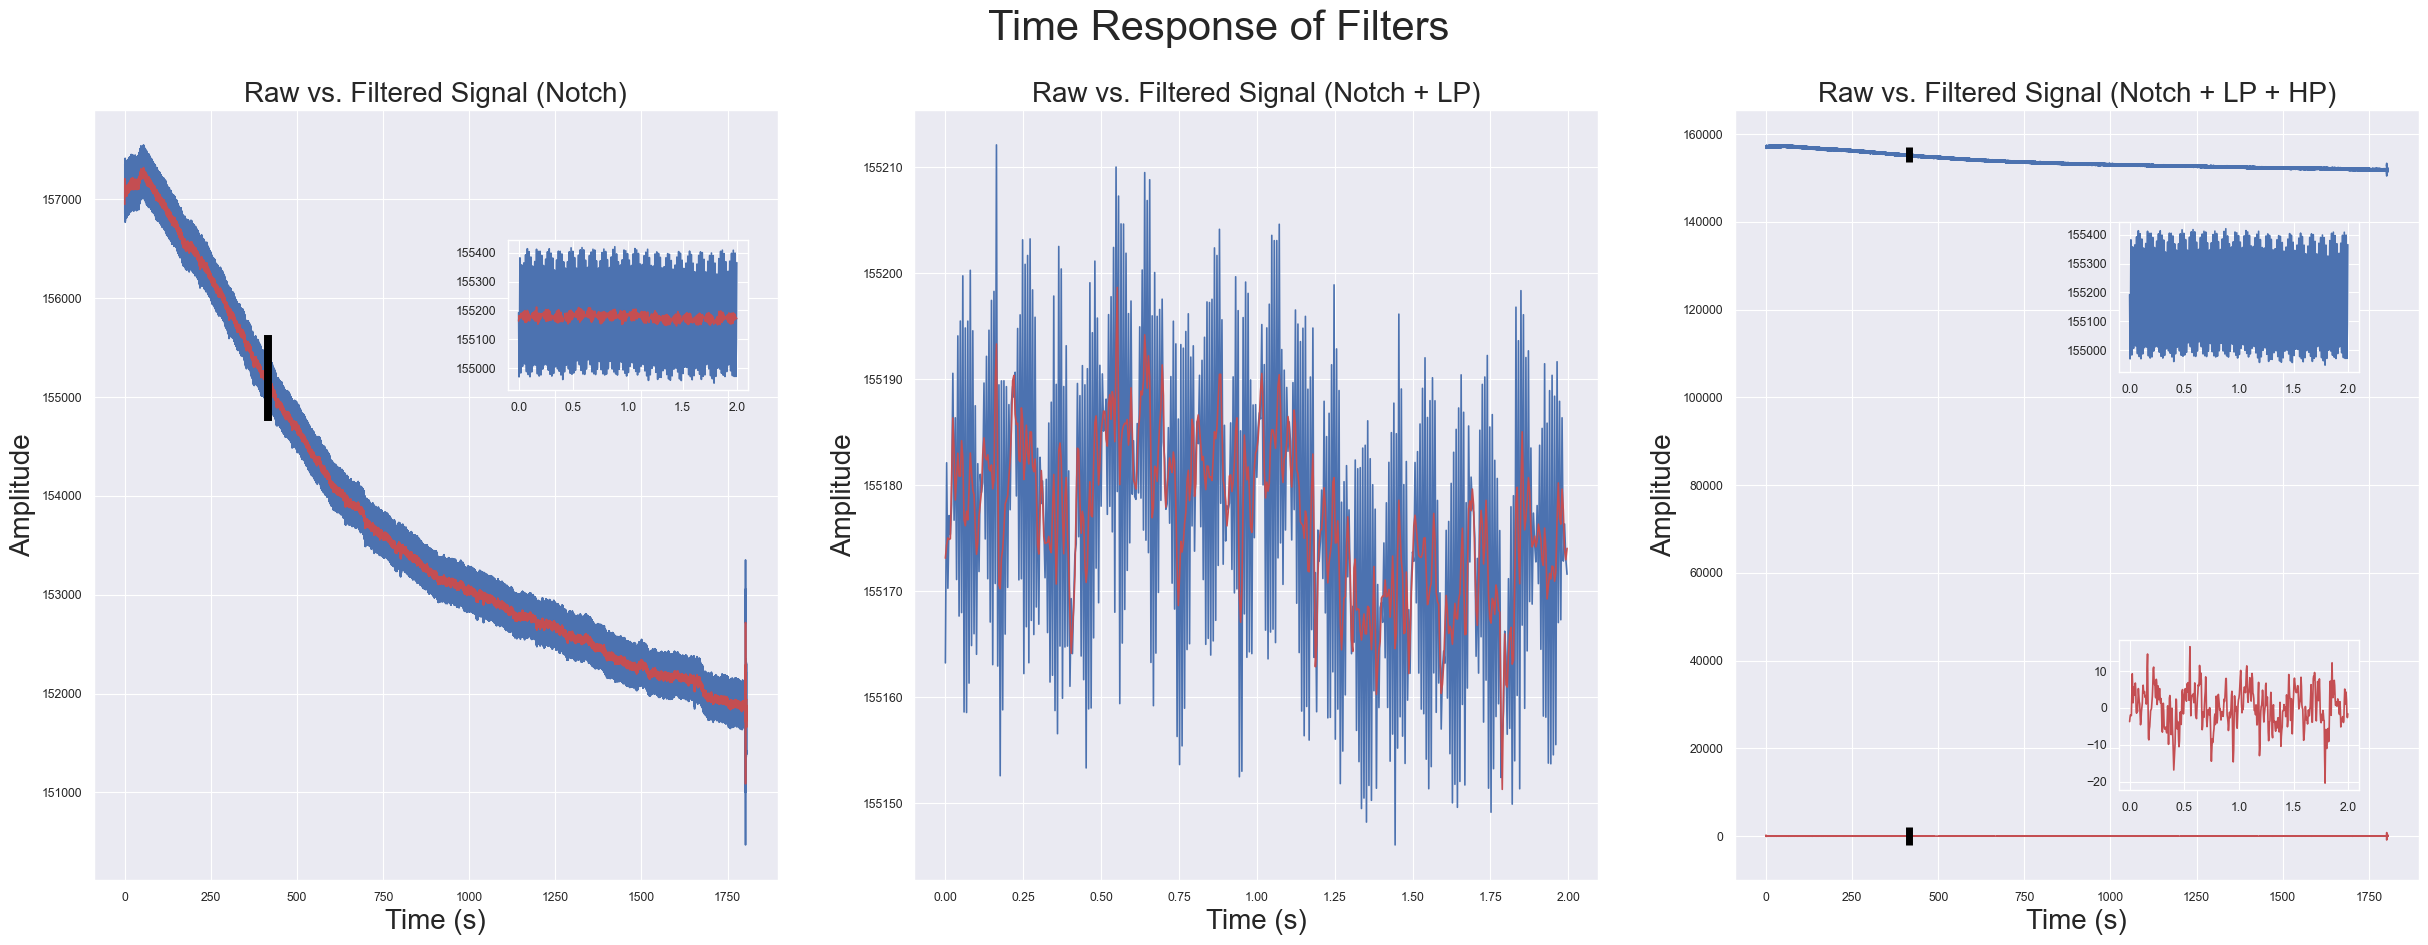

In [16]:
#For that we need to compare raw vs filtered data (for one channel)
raw_data_all = eeg_data[:,0]
raw_data_trial = eeg_data_trial[:,0]
filtered_eeg_data_all_notch = filtfilt(b_60, a_60, raw_data_all)
filtered_eeg_data_trial_notch = filtered_eeg_data_all_notch[start_idx: end_idx+1]
filtered_eeg_data_all_lp = filtfilt(taps_low, 1.0, filtered_eeg_data_all_notch)
filtered_eeg_data_trial_lp = filtered_eeg_data_all_lp[start_idx: end_idx+1]
filtered_eeg_data_all_hp = filtfilt(taps_high, 1.0, filtered_eeg_data_all_lp)
filtered_eeg_data_trial_hp = filtered_eeg_data_all_hp[start_idx: end_idx+1]
n = len(raw_data_all)
n_trial = 500

#Plotting
figure(1, figsize=(30,10))
clf()
grid(True)
suptitle('Time Response of Filters', fontsize=30)
subplot(1,3,1)
t = np.arange(0,n,1)/fs
plot(t,raw_data_all)
plot(t, filtered_eeg_data_all_notch, "r-")
xlabel('Time (s)', fontsize = 20)
ylabel('Amplitude', fontsize = 20)
title('Raw vs. Filtered Signal (Notch)', fontsize = 20)

# Create the rectangle and add it to the plot
min_y = 154800
max_y = 155600
current_axis = plt.gca()
rectangle = Rectangle((start_idx/fs, min_y), (end_idx-start_idx)/fs, max_y-min_y, fill=False, edgecolor='black', linewidth=5)
rectangle.set_zorder(2) #Let rectangle stay above previous plot
current_axis.add_patch(rectangle)

#Inset plot.
ax2 = axes([0.263, 0.6, 0.08, 0.15])
t = np.arange(0,n_trial,1)/fs
plot(t, raw_data_trial)
plot(t, filtered_eeg_data_trial_notch, "r-")

subplot(1,3,2)
t = np.arange(0,n_trial,1)/fs
plot(t, filtered_eeg_data_trial_notch)
plot(t, filtered_eeg_data_trial_lp, "r-")
xlabel('Time (s)', fontsize = 20)
ylabel('Amplitude', fontsize = 20)
title('Raw vs. Filtered Signal (Notch + LP)', fontsize = 20)

subplot(1,3,3)
t = np.arange(0,n,1)/fs
plot(t, raw_data_all)
plot(t, filtered_eeg_data_all_hp, "r-")
xlabel('Time (s)', fontsize = 20)
ylabel('Amplitude', fontsize = 20)
title('Raw vs. Filtered Signal (Notch + LP + HP)', fontsize = 20)

# Create two rectangles and add it to the plot
min_y = 153600
max_y = 157000
min_y2 = -2000
max_y2 = 2000
current_axis = plt.gca()
rectangle1 = Rectangle((start_idx/fs, min_y), (end_idx-start_idx)/fs, max_y-min_y, fill=False, edgecolor='black', linewidth=5)
rectangle2 = Rectangle((start_idx/fs, min_y2), (end_idx-start_idx)/fs, max_y2-min_y2, fill=False, edgecolor='black', linewidth=5)
rectangle1.set_zorder(2) #Let rectangle stay above previous plot
rectangle2.set_zorder(2)
current_axis.add_patch(rectangle1)
current_axis.add_patch(rectangle2)

#Inset plot top.
ax2 = axes([0.8, 0.618, 0.08, 0.15])
t = np.arange(0,n_trial,1)/fs
plot(t, raw_data_trial)

#Inset plot bottom
ax2 = axes([0.8, 0.2, 0.08, 0.15])
t = np.arange(0,n_trial,1)/fs
plot(t, filtered_eeg_data_trial_hp, "r-")

## Impulse Response and Step Response

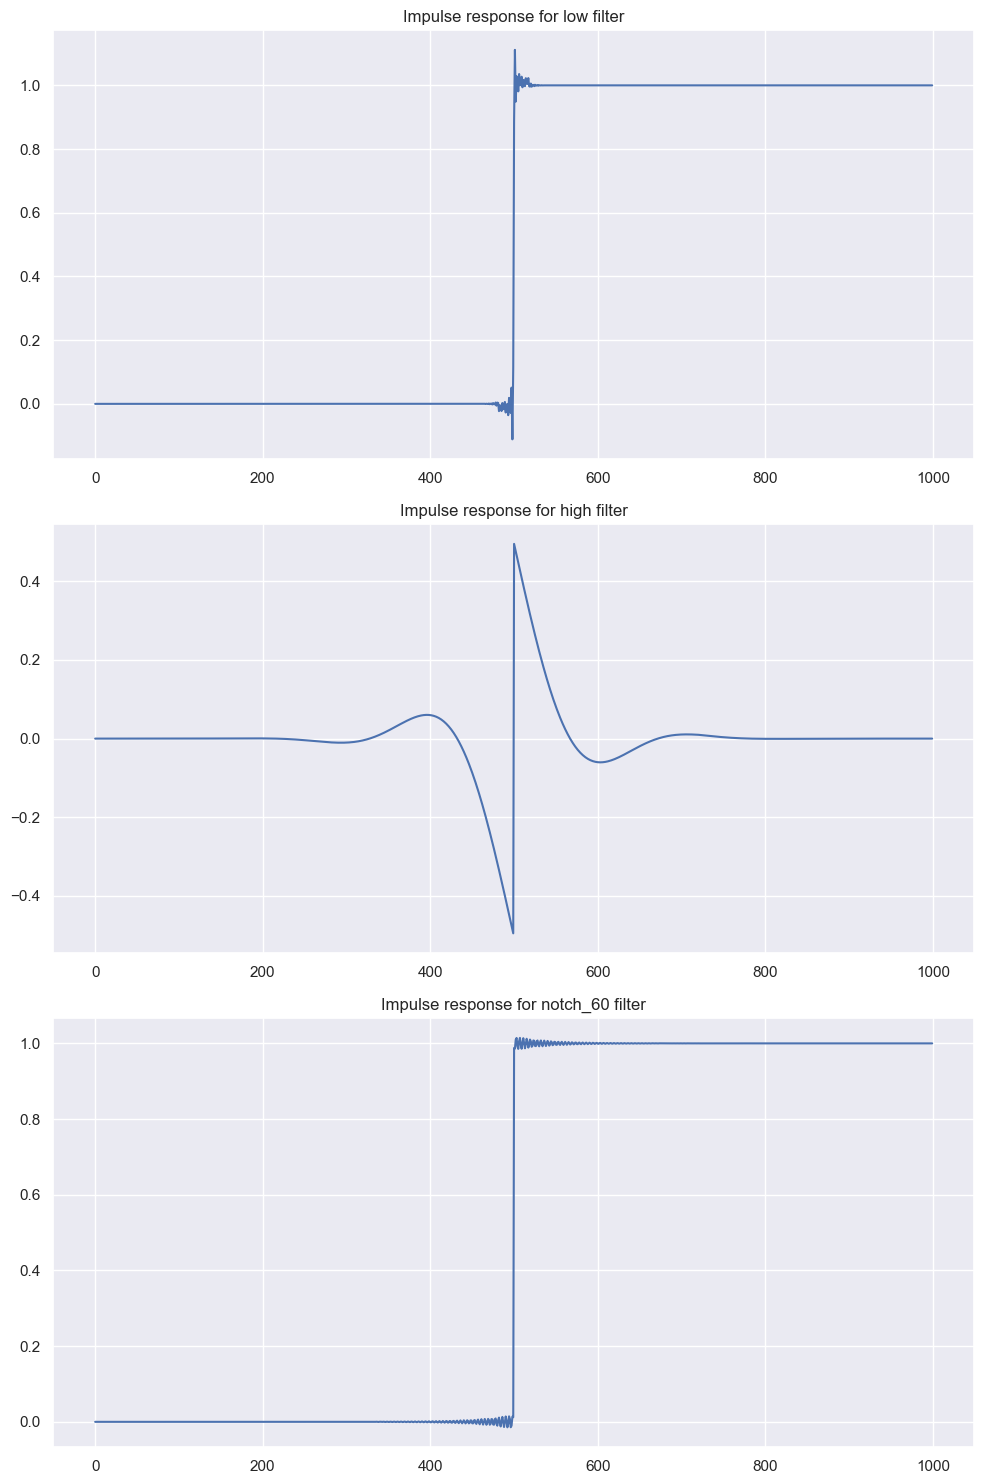

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

fs = 250
n_samples = eeg_data.shape[0]
nyq = fs/2.0

#Cutoff Frequencies
high_cut = 1.0/nyq
low_cut = 95/nyq
notch_cut1 = 60 #normalized inside scipy function

#Kaiser
#Highpass and Lowpass Filter 
#Width of transition from pass to stop relative to Nyquist.
width_low = 6.0/nyq 
width_high = 2.0/nyq

#Desired attenuation in the stop band, in dB.
ripple_db_low = 20.0
ripple_db_high = 72.0

#Compute the order and Kaiser parameter for the FIR filter.
N_low, beta_low = kaiserord(ripple_db_low, width_low)
N_high, beta_high = kaiserord(ripple_db_high, width_high)

#Use firwin with a Kaiser window to create a lowpass and highpass FIR filter.
taps_low = firwin(N_low, low_cut,window=('kaiser', beta_low)) #Kaiser: window=('kaiser', beta_low) or ('chebwin', 0.0002)
taps_high = firwin(N_high, high_cut, window=('kaiser', beta_high), pass_zero=False) 
w_h, h_h = freqz(taps_high, worN=512)
w_l, h_l = freqz(taps_low, worN=512)


#Notchfilter
b_60, a_60 = iirnotch(60.0, 30, fs=250)
w_60, h_60 = freqz(b_60, a_60, worN=512)

filter_coeffs = {
    "low": taps_low,
    "high": taps_high,
    "notch_60": (b_60, a_60),
    }

# Create impulse signal
impulse_or_step = "step"
if impulse_or_step == "impulse":
    impulse = np.zeros(1000)  # Adjust size to your needs
    impulse[0] = 1.0
else:
    impulse = np.zeros(1000)
    impulse[500:] = 1.0
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Filter the impulse signal and plot the impulse response for each filter
for idx, filter_key in enumerate(filter_coeffs.keys()):
    if type(filter_coeffs[filter_key]) == tuple:
        b, a = filter_coeffs[filter_key]
        #impulse_response = lfilter(b, a, impulse)
        impulse_response = filtfilt(b, a, impulse)
    else:
        #impulse_response = lfilter(filter_coeffs[filter_key], 1.0, impulse)
        impulse_response = filtfilt(filter_coeffs[filter_key], 1.0, impulse, padlen=0)
        
    axs[idx].plot(impulse_response)
    axs[idx].set_title(f'Impulse response for {filter_key} filter')

plt.tight_layout()
plt.show()


## Effect of Preprocessing on ERPs

Applying preprocessing...


Normalization: 100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


...done!


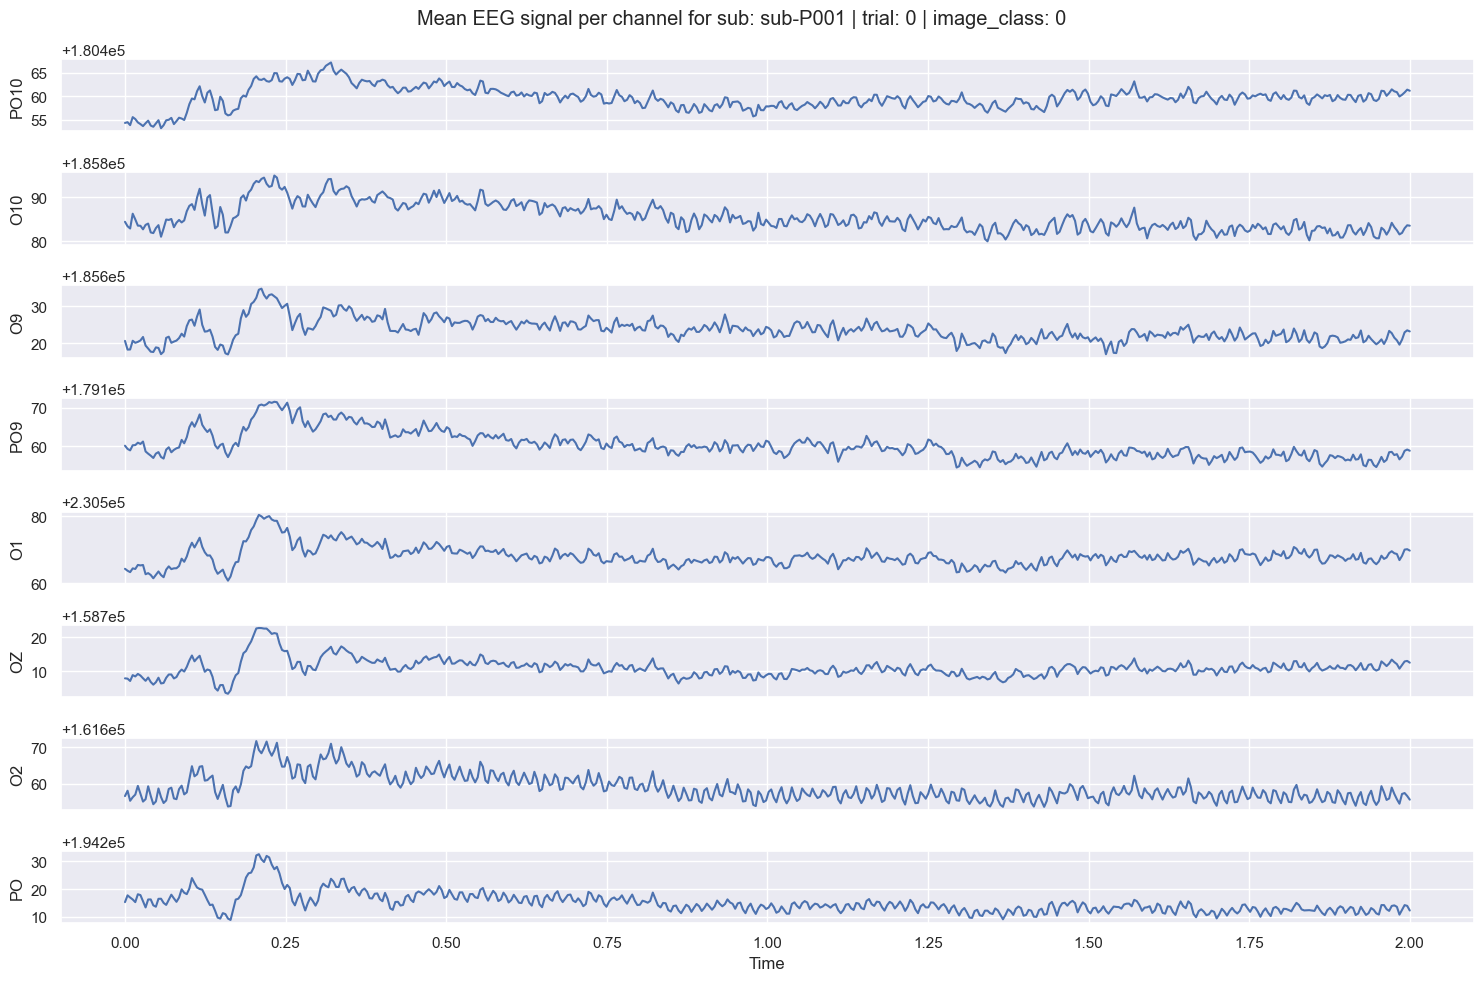

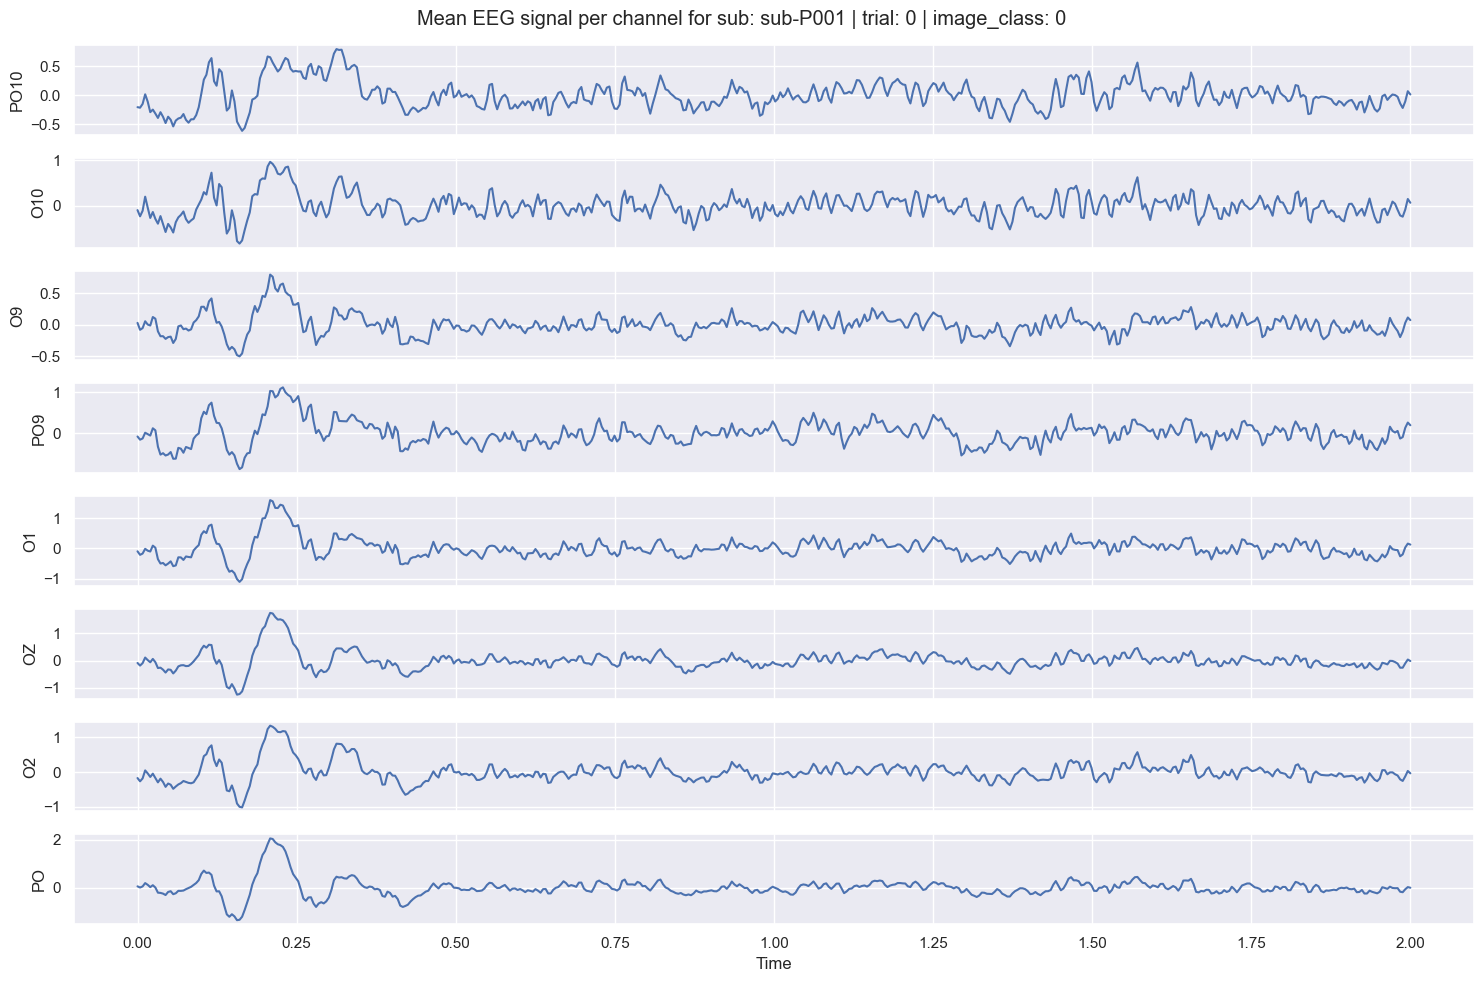

In [3]:
import os
os.chdir("C:/Users/s_gue/Desktop/master_project/sven-thesis/dataset")
from dataset_loader import DatasetLoader

subject_id = "P001"
#Specify directory where the recordings for one subject are stored
dir_path = "C:/Users/s_gue/Desktop/master_project/sven-thesis/data/recordings/sub-{}".format(subject_id)

preprocessing_params = {
    "notch_filter": {"freqs": [60.0]},
    "bandpass_filter": {
        "low": 1.0, 
        "high": 95.0,
        "width_low": 2.0, 
        "width_high": 6.0,
        "ripple_low": 72.0, 
        "ripple_high": 20.0
        },
    "normalization": {"per_channel": True, "clamp": 20.0},
    }

#Initialize DatasetLoader
A = DatasetLoader(
    dir_path, 
    sessions=[2], 
    runs = [2],
    fs = 250,
    event_time = 2,
    bad_detection_params = None,
    preprocessing_params = None,
    )

B = DatasetLoader(
    dir_path, 
    sessions=[2], 
    runs = [2],
    fs = 250,
    event_time = 2,
    bad_detection_params = None,
    preprocessing_params = preprocessing_params,
    )

A.plot_eeg_for_class(trial = 0, group_label = 0, img_name="no_preprocessing_class.png")
B.plot_eeg_for_class(trial = 0, group_label = 0, img_name="preprocessing_class.png")